In [1]:
import pandas as pd 
import numpy as np 
import dask.dataframe as dd
from pathlib import PurePath
from pathlib import PurePath, Path
import sys
import time
import os
import json
from tqdm import tqdm, tqdm_notebook
import mplfinance as mpf
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline
import seaborn as sns
sns.set_theme()

In [3]:
# Agregamos la carpeta que contiene 'py_modules' al PATH
sys.path.append(str(Path(r"C:\Users\oliva\Downloads\py_module").resolve()))

# Importamos las funciones
import snippets

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, auc

In [7]:
dollar_bars = pd.read_parquet(r"D:\bars\dollar_bars.parquet",  columns = ['open', 'close', 
'high', 'low', 'timestamp', 'volume'])

dollar_bars = dollar_bars.set_index('timestamp')

dollar_bars.head()

,open,close,high,low,volume
timestamp,,,,,
2023-01-01 00:00:04.118000,16537.5,16538.5,16540.9,16504.0,6051.460
2023-01-01 01:10:16.415000,16538.5,16524.0,16557.1,16519.5,6045.730
2023-01-01 03:05:26.072000,16524.0,16510.1,16532.3,16508.8,6051.973
2023-01-01 05:10:45.694999,16510.0,16521.8,16545.7,16508.0,6052.334
2023-01-01 07:06:36.842999,16521.8,16502.6,16530.3,16488.0,6057.291


In [9]:
filtered_data = dollar_bars['2023-01-01':'2023-01-14']

In [27]:
# Personalización de estilo
mc = mpf.make_marketcolors(up='g', down='r', wick='inherit', edge='inherit', volume='inherit')
s = mpf.make_mpf_style(marketcolors=mc)

# Gráfico de barras ohlc
mpf.plot(dollar_bars, type='candle', volume=True, style=s, title='OHLC Chart', ylabel='Price', savefig='ohlc_chart.png')

C:\Users\oliva\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


In [31]:
filtered_data = dollar_bars['2023-01-01':'2023-01-03']

# Gráfico de barras ohlc
mpf.plot(filtered_data, type='candle', volume=True, style=s, title='OHLC Chart - January 2023', ylabel='Price', savefig='ohlc_chart_january_2023.png')

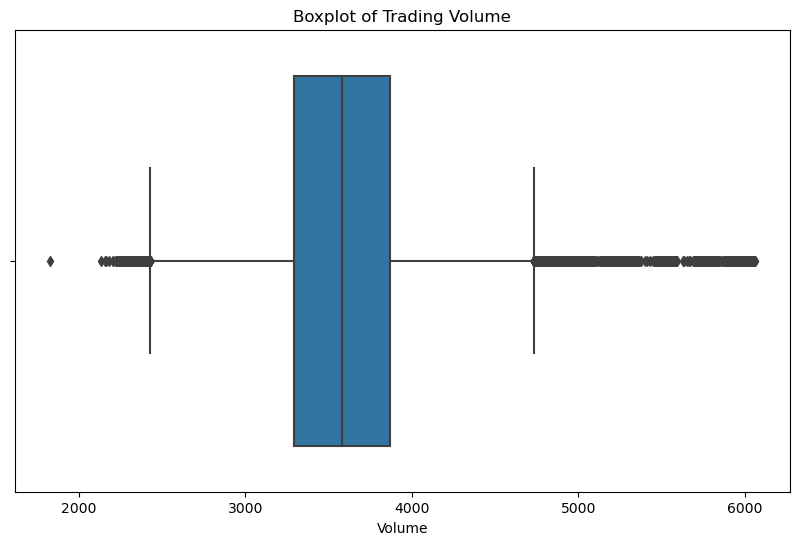

In [33]:
# Boxplot volumen
plt.figure(figsize=(10, 6))
sns.boxplot(x=dollar_bars['volume'])

plt.title('Boxplot of Trading Volume')
plt.xlabel('Volume')
plt.show()

In [11]:
dollar_bars['volume_fast_ema'] = dollar_bars['volume'].ewm(span=3, adjust=False).mean()
dollar_bars['volume_slow_ema'] = dollar_bars['volume'].ewm(span=20, adjust=False).mean()


print(dollar_bars)

                               open    close     high      low    volume  \
timestamp                                                                  
2023-01-01 00:00:04.118000  16537.5  16538.5  16540.9  16504.0  6051.460   
2023-01-01 01:10:16.415000  16538.5  16524.0  16557.1  16519.5  6045.730   
2023-01-01 03:05:26.072000  16524.0  16510.1  16532.3  16508.8  6051.973   
2023-01-01 05:10:45.694999  16510.0  16521.8  16545.7  16508.0  6052.334   
2023-01-01 07:06:36.842999  16521.8  16502.6  16530.3  16488.0  6057.291   
...                             ...      ...      ...      ...       ...   
2023-12-31 23:00:07.507000  42234.8  42350.0  42380.1  42211.0  2380.960   
2023-12-31 23:06:55.842000  42350.0  42224.0  42355.5  42175.9  2366.262   
2023-12-31 23:17:16.561000  42224.2  42116.4  42243.8  42083.1  2372.668   
2023-12-31 23:22:10.576000  42116.4  42260.5  42273.0  42111.8  2369.713   
2023-12-31 23:34:56.260000  42260.4  42314.0  42315.6  42222.2  1829.044   

           

In [13]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [15]:
window=50
dollar_bars['price'],dollar_bars['ave'],dollar_bars['upper'],dollar_bars['lower']=bbands(dollar_bars.close, window=window, numsd=1.5)
dollar_bars.dropna(inplace=True)
print(dollar_bars)

                               open    close     high      low    volume  \
timestamp                                                                  
2023-01-02 21:58:44.374000  16780.0  16734.3  16799.0  16728.1  5962.049   
2023-01-02 22:04:30.820000  16734.3  16703.0  16751.5  16685.2  5979.499   
2023-01-02 22:44:05.628999  16702.9  16701.6  16717.4  16683.5  5990.273   
2023-01-02 23:10:19.560000  16701.6  16669.3  16710.6  16666.1  5994.005   
2023-01-02 23:55:34.022000  16669.3  16670.0  16671.0  16639.5  6003.144   
...                             ...      ...      ...      ...       ...   
2023-12-31 23:00:07.507000  42234.8  42350.0  42380.1  42211.0  2380.960   
2023-12-31 23:06:55.842000  42350.0  42224.0  42355.5  42175.9  2366.262   
2023-12-31 23:17:16.561000  42224.2  42116.4  42243.8  42083.1  2372.668   
2023-12-31 23:22:10.576000  42116.4  42260.5  42273.0  42111.8  2369.713   
2023-12-31 23:34:56.260000  42260.4  42314.0  42315.6  42222.2  1829.044   

           

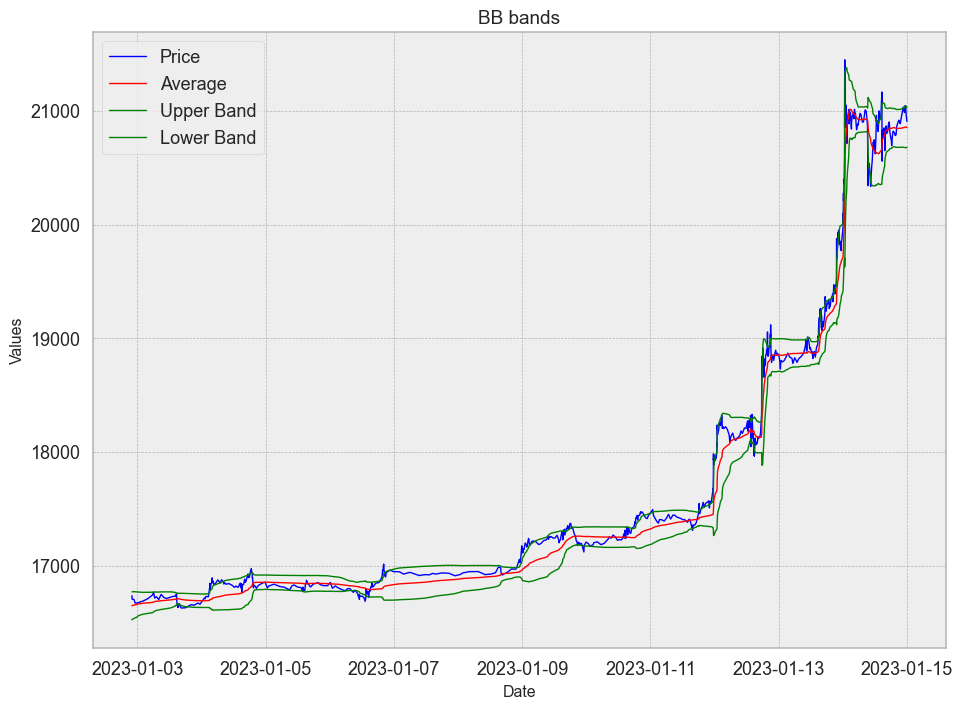

In [23]:
f, ax = plt.subplots(figsize=(11, 8))

ax.plot(filtered_data.index, filtered_data['price'], label='Price', color='blue', linewidth=1)
ax.plot(filtered_data.index, filtered_data['ave'], label='Average', color='red', linewidth=1)
ax.plot(filtered_data.index, filtered_data['upper'], label='Upper Band', color='green', linewidth=1)
ax.plot(filtered_data.index, filtered_data['lower'], label='Lower Band', color='green', linewidth=1)

ax.set_title('BB bands')
ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.legend()

plt.savefig('bb_bands_plot.png', format='png', dpi=800)

plt.show()

In [17]:
def get_up_cross(df, col):
    # col = columna precio
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(dollar_bars, 'price')
bb_up = get_up_cross(dollar_bars, 'price') 

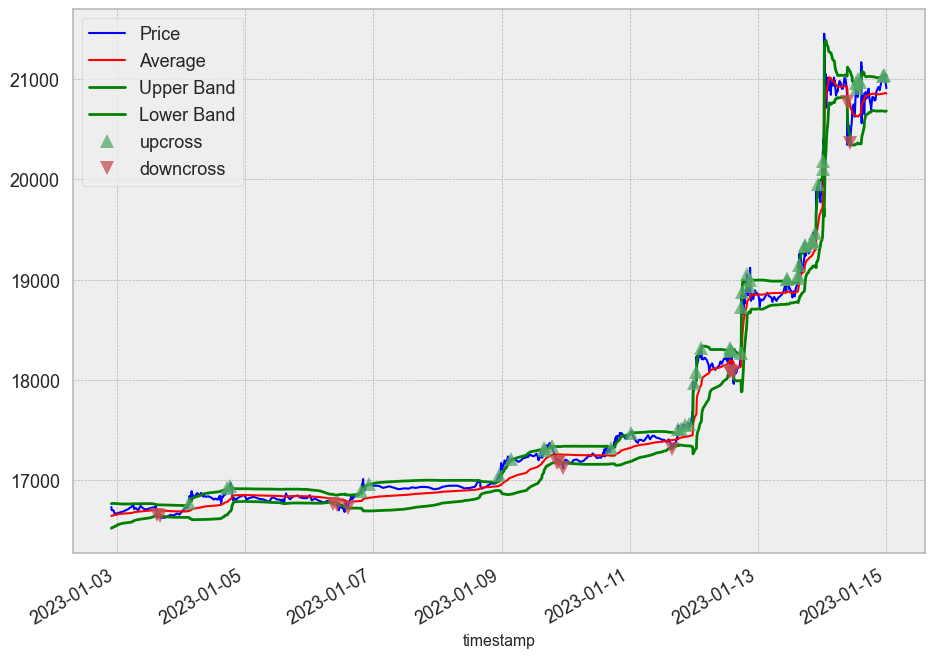

In [35]:
f, ax = plt.subplots(figsize=(11,8))

start_date = '2023-01-01'
end_date = '2023-01-14'

columns_to_plot = ['price', 'ave', 'upper', 'lower']

dollar_bars.loc[start_date:end_date, 'price'].plot(ax=ax, color='blue', label='Price', linewidth=1.5)
dollar_bars.loc[start_date:end_date, 'ave'].plot(ax=ax, color='red', label='Average', linewidth=1.5)

dollar_bars.loc[start_date:end_date, 'upper'].plot(ax=ax, color='green', label='Upper Band')
dollar_bars.loc[start_date:end_date, 'lower'].plot(ax=ax, color='green', label='Lower Band')

bb_up.loc[start_date:end_date].plot(ax=ax, ls='', marker='^', markersize=10,
                                    alpha=0.75, label='upcross', color='g')
bb_down.loc[start_date:end_date].plot(ax=ax, ls='', marker='v', markersize=10,
                                      alpha=0.75, label='downcross', color='r')

ax.legend()

plt.savefig('bb_bands_up_down_plot.png', format='png', dpi=800)

plt.show()

In [19]:
# sides
dollar_bars['side'] = np.nan


long_signals = (dollar_bars['close'] <= dollar_bars['lower']) #& (dollar_bars['volume_fast_ema'] > dollar_bars['volume_slow_ema'])
short_signals = (dollar_bars['close'] >= dollar_bars['upper']) #& (dollar_bars['volume_fast_ema'] < dollar_bars['volume_slow_ema'])

dollar_bars.loc[long_signals, 'side'] = 1
dollar_bars.loc[short_signals, 'side'] = -1

print(dollar_bars.side.value_counts())

# Look ahead bias
dollar_bars['side'] = dollar_bars['side'].shift(1)

side
-1.0    7049
 1.0    5930
Name: count, dtype: int64


In [21]:
data = dollar_bars.copy()

# Eliminamos valores NaN
dollar_bars.dropna(axis=0, how='any', inplace=True)

In [23]:
from snippets import getDailyVol, getTEvents, addVerticalBarrier, getEvents, getBins

# Definimos variable Close con precios de cierre
close = dollar_bars['close']

daily_vol = getDailyVol(close=close, span0=50)

In [25]:
daily_vol

timestamp
2023-01-04 17:33:10.450000         NaN
2023-01-04 18:36:45.221999    0.003223
2023-01-04 18:49:49.588000    0.002266
2023-01-04 18:57:49.012999    0.001849
2023-01-06 09:24:06.147000    0.012615
                                ...   
2023-12-31 23:00:07.507000    0.016798
2023-12-31 23:06:55.842000    0.016585
2023-12-31 23:17:16.561000    0.016434
2023-12-31 23:22:10.576000    0.016193
2023-12-31 23:34:56.260000    0.015928
Name: dailyVol, Length: 12953, dtype: float64

In [27]:
tEvents = getTEvents(close, h=daily_vol.mean()*0.1)

tEvents

100%|█████████████████████████████████████████████████████████████████████████| 12977/12977 [00:00<00:00, 57680.84it/s]


DatetimeIndex(['2023-01-03 15:37:07.015000', '2023-01-03 16:23:20.358000',
               '2023-01-04 03:06:58.868999', '2023-01-04 03:09:37.144999',
               '2023-01-04 03:15:08.068000', '2023-01-04 03:28:56.204999',
               '2023-01-04 03:59:58.644000', '2023-01-04 04:02:11.584999',
               '2023-01-04 04:36:02.236000', '2023-01-04 06:06:52.538000',
               ...
               '2023-12-31 09:19:35.640999', '2023-12-31 09:41:36.309999',
               '2023-12-31 09:45:29.996999', '2023-12-31 09:58:24.411000',
               '2023-12-31 22:51:28.448000', '2023-12-31 22:54:18.395000',
               '2023-12-31 23:00:07.507000', '2023-12-31 23:06:55.842000',
               '2023-12-31 23:17:16.561000', '2023-12-31 23:22:10.576000'],
              dtype='datetime64[ns]', length=7647, freq=None)

In [29]:
t1 = addVerticalBarrier(tEvents=tEvents, close=close, numDays=1)
t1

2023-01-03 15:37:07.015000   2023-01-04 17:33:10.450
2023-01-03 16:23:20.358000   2023-01-04 17:33:10.450
2023-01-04 03:06:58.868999   2023-01-06 09:24:06.147
2023-01-04 03:09:37.144999   2023-01-06 09:24:06.147
2023-01-04 03:15:08.068000   2023-01-06 09:24:06.147
                                       ...          
2023-12-30 15:56:05.616000   2023-12-31 22:51:28.448
2023-12-30 16:09:56.542000   2023-12-31 22:51:28.448
2023-12-30 16:30:42.545000   2023-12-31 22:51:28.448
2023-12-30 17:28:24.967000   2023-12-31 22:51:28.448
2023-12-30 17:32:28.073999   2023-12-31 22:51:28.448
Name: timestamp, Length: 7634, dtype: datetime64[ns]

In [31]:
# Reindexamos para evitar errores
daily_vol = daily_vol.reindex(daily_vol.index.union(tEvents))

In [33]:
from snippets import getEvents

pt_sl = [1, 1]
min_ret = 0.01

import platform
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1
    
events = getEvents(close=close,
                                  tEvents=tEvents,
                                  ptSl=pt_sl,
                                  trgt=daily_vol,
                                  minRet=min_ret,
                                  numThreads=cpus,
                                  t1=t1,
                                  side=data['side'])

In [34]:
print(events)

                                                   t1      trgt  side
2023-01-06 09:24:06.147000 2023-01-06 20:10:34.632000  0.012615   1.0
2023-01-06 11:05:44.468000 2023-01-06 19:54:11.056999  0.015757   1.0
2023-01-06 11:06:12.704000 2023-01-08 23:09:06.463000  0.016073   1.0
2023-01-06 12:51:26.711000 2023-01-06 19:54:11.056999  0.014820   1.0
2023-01-06 13:29:59.513999 2023-01-06 19:46:34.544000  0.014019   1.0
...                                               ...       ...   ...
2023-12-31 22:54:18.395000                        NaT  0.017072   1.0
2023-12-31 23:00:07.507000                        NaT  0.016798   1.0
2023-12-31 23:06:55.842000                        NaT  0.016585   1.0
2023-12-31 23:17:16.561000                        NaT  0.016434   1.0
2023-12-31 23:22:10.576000                        NaT  0.016193   1.0

[6881 rows x 3 columns]


In [37]:
from snippets import getBins

labels = getBins(events=events, close=data['close'])
labels.bin.value_counts()

bin
1.0    3507
0.0    3363
Name: count, dtype: int64

In [39]:
labels.dropna()

print(labels)

                                 ret  bin
2023-01-06 09:24:06.147000  0.013626  1.0
2023-01-06 11:05:44.468000  0.015801  1.0
2023-01-06 11:06:12.704000  0.018203  1.0
2023-01-06 12:51:26.711000  0.015041  1.0
2023-01-06 13:29:59.513999  0.014073  1.0
...                              ...  ...
2023-12-30 16:30:42.545000  0.006038  1.0
2023-12-30 17:28:24.967000  0.008427  1.0
2023-12-30 17:32:28.073999  0.006241  1.0
2023-12-31 02:49:06.835000  0.014370  1.0
2023-12-31 09:41:36.309999  0.018559  1.0

[6870 rows x 2 columns]


### Añadimos más features (características) a la matriz.

In [42]:
data['log_ret'] = np.log(data['close']).diff()

# Autocorrelación
window_autocorr = 50
data['autocorr_1'] = (data['log_ret']
                          .rolling(window=window_autocorr, 
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=1), raw=False))

data['autocorr_2'] = (data['log_ret']
                          .rolling(window=window_autocorr, 
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=3), raw=False))

data['autocorr_3'] = (data['log_ret']
                          .rolling(window=window_autocorr, 
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=5), raw=False))

# Volatilidad
data['volatilty'] = events.trgt

# Fast and slow EMAs
fast_window = 7
slow_window = 15

data['fast_ema'] = (data['close']
                    .ewm(span=fast_window, min_periods=fast_window, adjust=False)
                    .mean())

data['slow_ema'] = (data['close']
                    .ewm(span=slow_window, min_periods=slow_window, adjust=False)
                    .mean())

In [43]:
data['ema'] = np.nan

long_signals = data['fast_ema'] >= data['slow_ema']
short_signals = data['fast_ema'] < data['slow_ema']
data.loc[long_signals, 'ema'] = 1
data.loc[short_signals, 'ema'] = -1

In [44]:
# Sides
data['side'] = np.nan


long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

side
-1.0    7049
 1.0    5930
Name: count, dtype: int64


In [45]:
# Look ahead bias
data['side'] = data['side'].shift(1)

In [46]:
print(data)

                               open    close     high      low    volume  \
timestamp                                                                  
2023-01-02 21:58:44.374000  16780.0  16734.3  16799.0  16728.1  5962.049   
2023-01-02 22:04:30.820000  16734.3  16703.0  16751.5  16685.2  5979.499   
2023-01-02 22:44:05.628999  16702.9  16701.6  16717.4  16683.5  5990.273   
2023-01-02 23:10:19.560000  16701.6  16669.3  16710.6  16666.1  5994.005   
2023-01-02 23:55:34.022000  16669.3  16670.0  16671.0  16639.5  6003.144   
...                             ...      ...      ...      ...       ...   
2023-12-31 23:00:07.507000  42234.8  42350.0  42380.1  42211.0  2380.960   
2023-12-31 23:06:55.842000  42350.0  42224.0  42355.5  42175.9  2366.262   
2023-12-31 23:17:16.561000  42224.2  42116.4  42243.8  42083.1  2372.668   
2023-12-31 23:22:10.576000  42116.4  42260.5  42273.0  42111.8  2369.713   
2023-12-31 23:34:56.260000  42260.4  42314.0  42315.6  42222.2  1829.044   

           

In [47]:
# Eliminamos valores NaN
data.dropna(axis=0, how='any', inplace=True)

print(data)

                               open    close     high      low    volume  \
timestamp                                                                  
2023-01-06 09:24:06.147000  16763.5  16784.1  16787.5  16762.3  5961.295   
2023-01-06 11:05:44.468000  16757.0  16701.3  16757.0  16685.2  5982.481   
2023-01-06 11:06:12.704000  16701.3  16744.7  16747.5  16700.0  5976.751   
2023-01-06 12:51:26.711000  16731.2  16713.8  16738.8  16697.2  5983.687   
2023-01-06 13:29:59.513999  16685.0  16720.0  16720.0  16664.8  5991.168   
...                             ...      ...      ...      ...       ...   
2023-12-31 22:54:18.395000  42309.4  42234.8  42392.2  42234.8  2345.610   
2023-12-31 23:00:07.507000  42234.8  42350.0  42380.1  42211.0  2380.960   
2023-12-31 23:06:55.842000  42350.0  42224.0  42355.5  42175.9  2366.262   
2023-12-31 23:17:16.561000  42224.2  42116.4  42243.8  42083.1  2372.668   
2023-12-31 23:22:10.576000  42116.4  42260.5  42273.0  42111.8  2369.713   

           

In [48]:
# Reindexamos para tener las caracterñisticas correspondientes a las fechas de los eventos
X = data.reindex(labels.index)


# Eliminamos columnas innecesarias
X.drop(['ave', 'upper', 'lower', 'open', 'high', 'low', 'close',
        'volume', 'price', 'fast_ema', 'slow_ema', 'volume_fast_ema', 'volume_slow_ema'], axis=1, inplace=True)
Xy = (pd.merge_asof(X, labels[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
print(Xy)

                            side   log_ret  autocorr_1  autocorr_2  \
2023-01-06 09:24:06.147000   1.0  0.001228   -0.210695    0.087116   
2023-01-06 11:05:44.468000   1.0 -0.003330   -0.248096    0.151586   
2023-01-06 11:06:12.704000   1.0  0.002595   -0.295995    0.182200   
2023-01-06 12:51:26.711000   1.0 -0.001041   -0.312861    0.227550   
2023-01-06 13:29:59.513999   1.0  0.002095   -0.343360    0.248535   
...                          ...       ...         ...         ...   
2023-12-30 16:30:42.545000  -1.0 -0.001253   -0.021319    0.036085   
2023-12-30 17:28:24.967000  -1.0  0.000439    0.046335    0.024587   
2023-12-30 17:32:28.073999  -1.0 -0.002202    0.029335   -0.012172   
2023-12-31 02:49:06.835000   1.0  0.002615   -0.073077   -0.142068   
2023-12-31 09:41:36.309999  -1.0  0.002819    0.052907   -0.096533   

                            autocorr_3  volatilty  ema  bin  
2023-01-06 09:24:06.147000   -0.009782   0.012615 -1.0  1.0  
2023-01-06 11:05:44.468000   -0.095

In [49]:
X = Xy.drop('bin',axis=1)
y = Xy['bin']

In [50]:
print(X)

                            side   log_ret  autocorr_1  autocorr_2  \
2023-01-06 09:24:06.147000   1.0  0.001228   -0.210695    0.087116   
2023-01-06 11:05:44.468000   1.0 -0.003330   -0.248096    0.151586   
2023-01-06 11:06:12.704000   1.0  0.002595   -0.295995    0.182200   
2023-01-06 12:51:26.711000   1.0 -0.001041   -0.312861    0.227550   
2023-01-06 13:29:59.513999   1.0  0.002095   -0.343360    0.248535   
...                          ...       ...         ...         ...   
2023-12-30 16:30:42.545000  -1.0 -0.001253   -0.021319    0.036085   
2023-12-30 17:28:24.967000  -1.0  0.000439    0.046335    0.024587   
2023-12-30 17:32:28.073999  -1.0 -0.002202    0.029335   -0.012172   
2023-12-31 02:49:06.835000   1.0  0.002615   -0.073077   -0.142068   
2023-12-31 09:41:36.309999  -1.0  0.002819    0.052907   -0.096533   

                            autocorr_3  volatilty  ema  
2023-01-06 09:24:06.147000   -0.009782   0.012615 -1.0  
2023-01-06 11:05:44.468000   -0.095434   0.01

In [51]:
print(y)

2023-01-06 09:24:06.147000    1.0
2023-01-06 11:05:44.468000    1.0
2023-01-06 11:06:12.704000    1.0
2023-01-06 12:51:26.711000    1.0
2023-01-06 13:29:59.513999    1.0
                             ... 
2023-12-30 16:30:42.545000    1.0
2023-12-30 17:28:24.967000    1.0
2023-12-30 17:32:28.073999    1.0
2023-12-31 02:49:06.835000    1.0
2023-12-31 09:41:36.309999    1.0
Name: bin, Length: 6870, dtype: float64


## Primary Model Performance

In [54]:
primary_forecast = pd.DataFrame(y)
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Métricas
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3363
         1.0       0.51      1.00      0.68      3507

    accuracy                           0.51      6870
   macro avg       0.26      0.50      0.34      6870
weighted avg       0.26      0.51      0.35      6870

Confusion Matrix
[[   0 3363]
 [   0 3507]]

Accuracy
0.5104803493449782


C:\Users\oliva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\oliva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\oliva\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Entramiento Modelo

In [67]:
# Separamos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [69]:
n_estimator = 1000
depth = 2

rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', class_weight='balanced_subsample',
                            random_state=7)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, n_estimators=1000, random_state=7)

### Evaluación Entrenamiento

              precision    recall  f1-score   support

         0.0       0.55      0.59      0.57      2752
         1.0       0.56      0.52      0.54      2744

    accuracy                           0.56      5496
   macro avg       0.56      0.56      0.56      5496
weighted avg       0.56      0.56      0.56      5496

Confusion Matrix
[[1635 1117]
 [1320 1424]]

Accuracy
0.5565866084425036


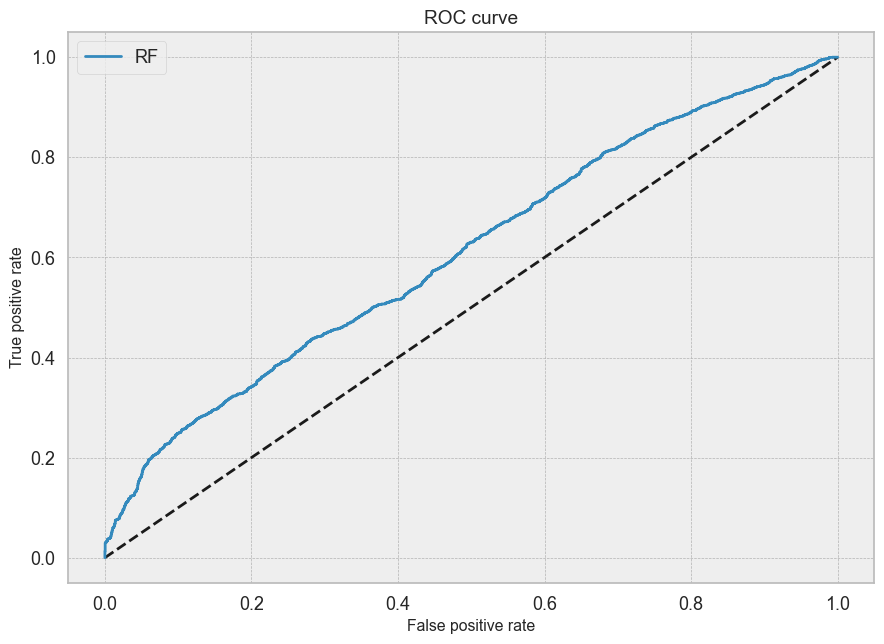

In [72]:
# Métricas
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Importancia de las características

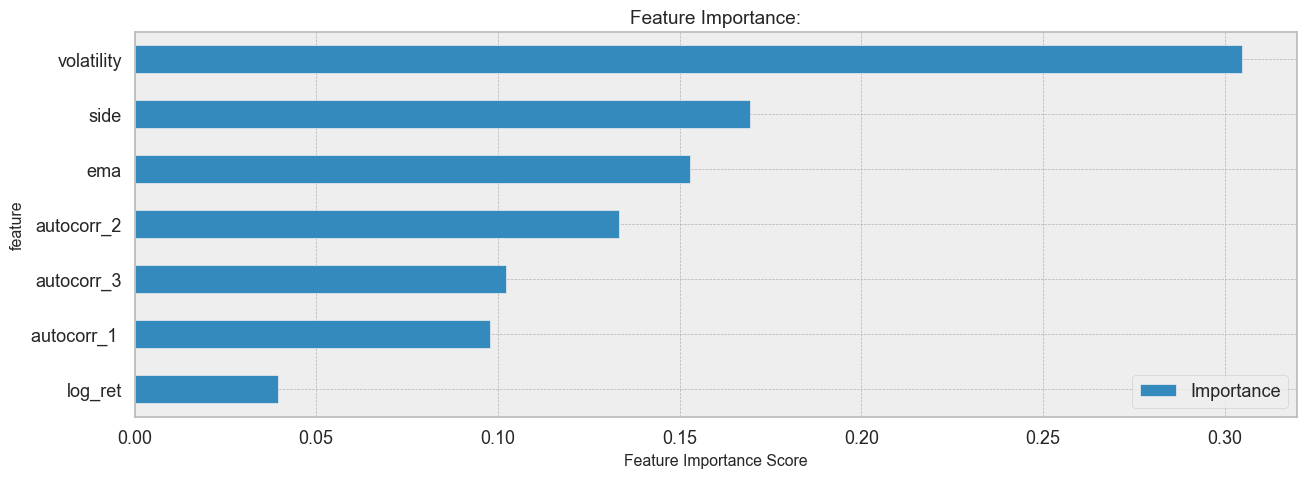

In [75]:
# Listado de características
feature_names = ['side', 'log_ret', 'autocorr_1 ', 'autocorr_2', 'autocorr_3', 'volatility', 'ema'] 

# Convertir X a un DataFrame
X_df = pd.DataFrame(X, columns=feature_names)

title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X_df.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

### Evaluación Prueba

              precision    recall  f1-score   support

         0.0       0.48      0.55      0.52       611
         1.0       0.59      0.52      0.56       763

    accuracy                           0.54      1374
   macro avg       0.54      0.54      0.54      1374
weighted avg       0.54      0.54      0.54      1374

Confusion Matrix
[[338 273]
 [363 400]]

Accuracy
0.537117903930131


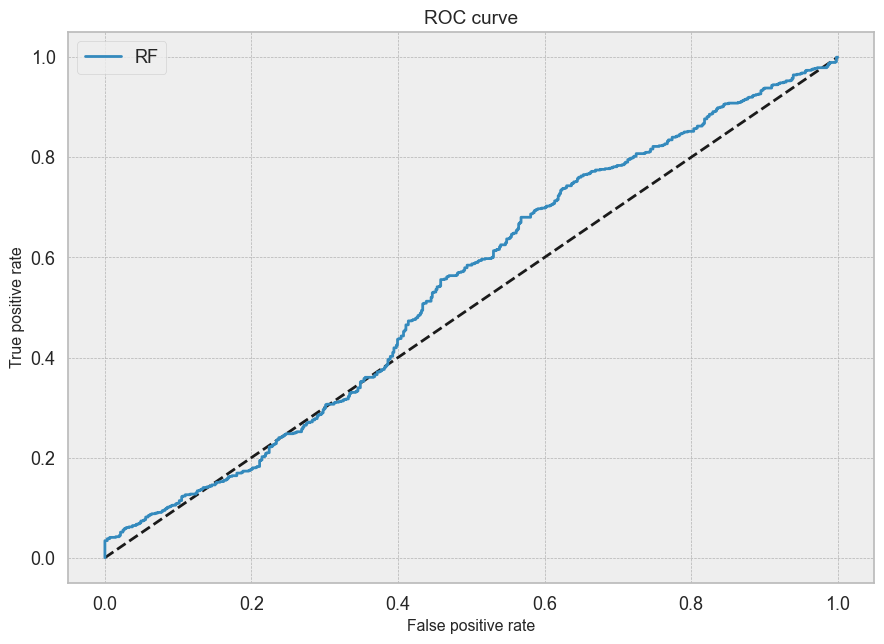

In [78]:
# Métricas
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Portfolio stats

In [124]:
pip install quantstats

  Obtaining dependency information for quantstats from https://files.pythonhosted.org/packages/bc/02/306226b38cc51972853f56866a566f224cf3855d1e3b492a774fb00c71a5/QuantStats-0.0.62-py2.py3-none-any.whl.metadata
  Obtaining dependency information for yfinance>=0.1.70 from https://files.pythonhosted.org/packages/39/29/89572cb0c65b07a1c4e5cd53eb0a0f947f2ece53fef6ed7da90cfab7d2a9/yfinance-0.2.43-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/6a/71/3656c00606e75e81f11721e6a1c973c3e03da8c7d8b665d20f78245384c6/frozendict-2.4.4-py311-none-any.whl.metadata
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     - -------------------------------------- 0.1/3.0 MB 2.6 MB/s eta 0:00

In [134]:
print(returns.head())  
print(returns.describe())  


2023-10-24 02:11:10.784000    0.030135
2023-10-24 02:15:34.704999    0.028059
2023-10-24 02:17:20.683000    0.031349
2023-10-24 02:21:46.395000    0.027225
2023-10-24 02:23:10.328000    0.029104
Name: ret, dtype: float64
count    1368.000000
mean        0.003097
std         0.019484
min        -0.055074
25%        -0.009707
50%         0.008482
75%         0.018122
max         0.041014
Name: ret, dtype: float64


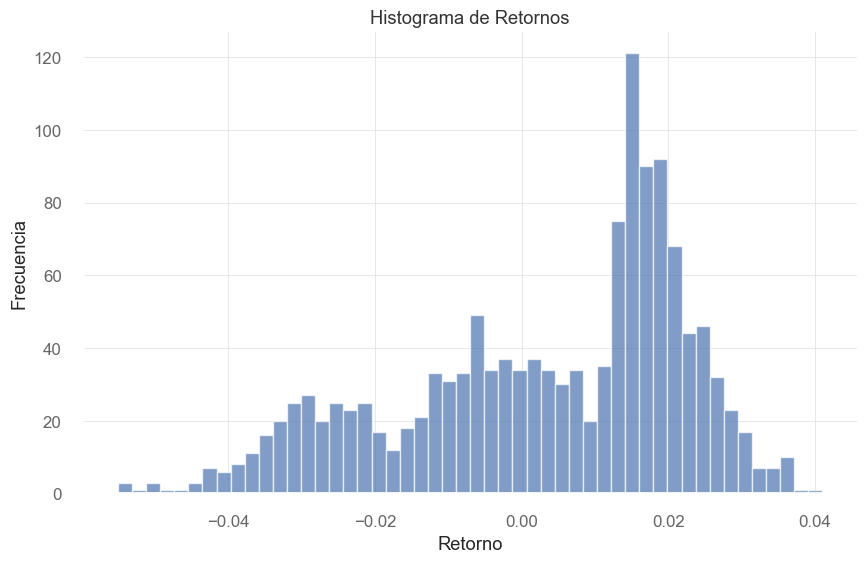

In [146]:
import matplotlib.pyplot as plt

# Histograma de los retornos
plt.figure(figsize=(10, 6))
returns.plot(kind='hist', bins=50, alpha=0.7)
plt.title('Histograma de Retornos')
plt.xlabel('Retorno')
plt.ylabel('Frecuencia')
plt.show()


In [148]:
print("Ejemplos de los datos:")
print(returns.head())

Ejemplos de los datos:
2023-10-24 02:11:10.784000    0.030135
2023-10-24 02:15:34.704999    0.028059
2023-10-24 02:17:20.683000    0.031349
2023-10-24 02:21:46.395000    0.027225
2023-10-24 02:23:10.328000    0.029104
Name: ret, dtype: float64


In [138]:
print("Rango de fechas en los retornos:", returns.index.min(), "a", returns.index.max())


Rango de fechas en los retornos: 2023-10-24 02:11:10.784000 a 2023-12-31 09:41:36.309999


In [89]:
print("Frecuencia del índice:", returns.index.inferred_freq)

Frecuencia del índice: None


In [91]:
# Resampling para una frecuencia válida -> diaria
returns_resampled = returns.resample('D').ffill()  

print(returns_resampled.head())

2023-10-24         NaN
2023-10-25   -0.022395
2023-10-26   -0.006354
2023-10-27    0.002005
2023-10-28    0.025236
Freq: D, Name: ret, dtype: float64


In [93]:
test_dates = X_test.index

returns = labels.loc[test_dates, 'ret']

start_date = '2023-10-24'
end_date = '2023-12-31'
returns_resampled = returns_resampled.loc[start_date:end_date]

# Generamos el informe HTML
qs.reports.html(returns_resampled, title='Performance Report', output='quantstats_report_resampled.html')

# Métricas básicas
print(qs.reports.metrics(returns_resampled))

                    Strategy
------------------  ----------
Start Period        2023-10-25
End Period          2023-12-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   43.54%
CAGR﹪              289.38%

Sharpe              5.87
Prob. Sharpe Ratio  99.87%
Sortino             11.01
Sortino/√2          7.79
Omega               2.29

Max Drawdown        -5.8%
Longest DD Days     6

Gain/Pain Ratio     1.29
Gain/Pain (1M)      -

Payoff Ratio        1.33
Profit Factor       2.29
Common Sense Ratio  2.86
CPC Index           1.92
Tail Ratio          1.25
Outlier Win Ratio   2.39
Outlier Loss Ratio  1.92

MTD                 15.61%
3M                  43.54%
6M                  43.54%
YTD                 43.54%
1Y                  43.54%
3Y (ann.)           289.38%
5Y (ann.)           289.38%
10Y (ann.)          289.38%
All-time (ann.)     289.38%

Avg. Drawdown       -1.82%
Avg. Drawdown Days  2
Recovery Factor     6.38
Ulcer Index         0.01
Serenity Index      1